# **Part 2** - Write documentation on the plan & design you will be following to build this automated machine learning system.

1.	Introduction.
In designing an automated machine learning (ML) system for production, the goal is to create a scalable, maintainable, and efficient ML pipeline. My system will enable automated data preprocessing, model training, evaluation and deployment ensuring the model remains effective and adapts to new data over time.
2.	System Overview.
The system will be structured as an end-to-end ML pipeline with the following stages.
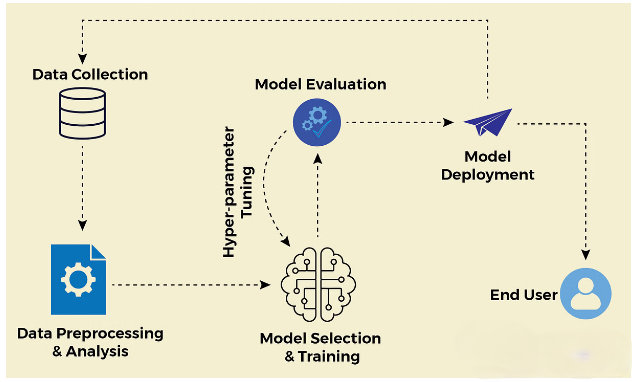


A. Data Preprocessing.
1.	Combine Datasets - Use the join method to merge datasets into a single dataset, creating a comprehensive deployment dataset.
2.	Select Target and Input Features - Choose the target column and relevant input features from the combined dataset.
3.	Encode Categorical Columns - Apply label encoding to convert categorical variables into numerical form.
4.	Split Data - Divide the dataset into training (80%) and testing (20%) sets.
5.	Impute Missing Values - Fill missing values using mean values.

B. Feature Engineering.
1.	Calculate Mutual Information - Measure the mutual information between the target variable and each feature.
2.	Set Feature Selection Threshold - Choose a threshold value (0.05) to select the top features based on their mutual information scores.
3.	Save Preprocessing Artifacts - Store encoder values imputed mean values, and the selected top features for deployment.

C. Model Selection and Training.
1.	Choose LightGBM Model - Use LGBMClassifier and configure model parameters.
2.	Hyperparameter Tuning - Perform hyperparameter tuning using RandomizedSearchCV.
3.	Cross-Validation - Validate model performance with cross-validation.
4.	Get Best Model - Retrieve the model with optimal parameters.

D. Model Evaluation.
1.	Evaluate with AUC - Assess model performance on the test set using the Area Under the Curve (AUC) metric.
2.	Plot Training and Validation Performance - Visualize the model’s performance over training and validation phases.
3.	Plot Confusion Matrix - Create a confusion matrix to analyze classification outcomes.
4.	Generate Classification Report - Obtain a detailed classification report.

E. Save the Model for Deployment.
1.	Save the trained model - For future deployment and use.

F. Model Deployment.
1.	Load Saved Model - Load the trained LightGBM model.
2.	Load Deployment Dataset - Load the dataset prepared for deployment testing.
3.	Load Encoders and Imputer Values - Retrieve saved encoder mappings and imputed mean values.
4.	Load Selected Features - Load the top features identified during feature selection.
5.	Apply Preprocessing - Use saved preprocessing values to prepare the new dataset.
6.	Predict Model Accuracy - Evaluate the model's accuracy on the new dataset.



In [1]:
import pandas as pd

# Load the datasets
loan_df = pd.read_csv(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\data\data\loan.csv')
payment_df = pd.read_csv(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\data\data\payment.csv')
clarity_df = pd.read_csv(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\data\data\clarity_underwriting_variables.csv', low_memory=False)

# Merge loan and payment datasets on loanId using left join
loan_payment_merged = pd.merge(loan_df, payment_df, on='loanId', how='left')

# Merge with clarity_underwriting_variables dataset on clarityFraudId and underwritingid using left join
data = pd.merge(loan_payment_merged, clarity_df, left_on='clarityFraudId', right_on='underwritingid', how='left')

# Randomly select 10 rows for testing and deploying purpose data
test_sample = data.sample(n=10, random_state=42)

# Drop the selected rows from the original dataset which are used for deploying data set
data = data.drop(test_sample.index)
test_sample.to_csv(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\New_data\test_sample.csv', index=False)

# Save the merged data to the same folder as "merged_data.csv"
output_file_path = r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\New_data\merged_data.csv'
data.to_csv(output_file_path, index=False)

# Output confirmation
print(f"Data loaded and merged successfully. Saved to {output_file_path}")

Data loaded and merged successfully. Saved to C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\New_data\merged_data.csv


In [2]:
# Load necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.metrics import precision_recall_curve
import joblib
import os
import lightgbm as lgb
from lightgbm import early_stopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

In [3]:

class AutoMLPipeline:
    def __init__(self, target_col, model_type='lightgbm', input_features=None, feature_selection_threshold=0.05):
        """
        Initialize the AutoMLPipeline with target column, model type, and other configurations.

        Parameters:
        - target_col: str - The target column in the dataset.
        - model_type: str - Model type 'lightgbm' selected.
        - input_features: List of specific features to use for model prediction.
        - feature_selection_threshold: float - Threshold for mutual information feature selection.

        """
        self.target_col = target_col
        self.model_type = model_type
        self.input_features = input_features
        self.feature_selection_threshold = feature_selection_threshold
        self.data = None
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.selected_features = None # To store selected features after feature engineering
        self.encoders = {}  # To store encoders for each categorical column values
        self.imputer = None  # To store the imputer values

    def load_data(self, *paths):
        """
        Load and merge multiple datasets. Automatically finds and merges on common columns.
        """
        self.data = pd.read_csv(paths[0])
        print("Data loaded successfully.")

    def preprocess_data(self):
        # Detect and encode categorical columns
        categorical_cols = self.data.select_dtypes(include=['object', 'category']).columns.tolist()

        # Encode and save each categorical column's encoder using label encoder
        for col in categorical_cols:
            if col in self.data.columns:
                label_encoder = LabelEncoder()
                self.data[col] = label_encoder.fit_transform(self.data[col].astype(str))
                self.encoders[col] = label_encoder  # Store encoder value for deployment purpose

        # Filter columns based on input features
        if self.input_features:
            self.data = self.data[self.input_features + [self.target_col]]

        print("Data preprocessing completed. Using input features:", self.input_features)


    def split_data(self, test_size=0.2, random_state=42):
        """
        Split data into training and testing sets.
        """
        X = self.data.drop(columns=[self.target_col])
        y = self.data[self.target_col]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print("Data split into train and test sets.")

    def feature_engineering(self):
        """
        Impute missing values and select high mutual information features.
        Return the selected features.
        """
        self.imputer  = SimpleImputer(strategy='mean')
        X_train_imputed = self.imputer.fit_transform(self.X_train)
        X_test_imputed = self.imputer.transform(self.X_test)

        # Calculate mutual information
        mutual_info = mutual_info_classif(X_train_imputed, self.y_train)
        mutual_info = pd.Series(mutual_info, index=self.X_train.columns).sort_values(ascending=False)

        high_mi_features = mutual_info[mutual_info > self.feature_selection_threshold]
        sel_k_cols = SelectKBest(mutual_info_classif, k=len(high_mi_features))
        sel_k_cols.fit(X_train_imputed, self.y_train)

        self.selected_features = self.X_train.columns[sel_k_cols.get_support()]
        self.X_train = self.X_train[self.selected_features]
        self.X_test = self.X_test[self.selected_features]

        mutual_info.plot.bar(figsize=(20, 8))
        #print(high_mi_features)
        print(len(high_mi_features))
        print()
        print("Feature engineering completed.")

        self.X_train_selected = sel_k_cols.transform(X_train_imputed)
        self.X_test_selected = sel_k_cols.transform(X_test_imputed)

        return self.imputer,self.selected_features

    def save_encoders_and_imputer(self, save_dir=r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\preprocessors'):
        """
        Save each encoder and the imputer to the specified directory.

        Parameters:
        - save_dir: str - The directory path to save the encoder and imputer files.

        """
        # Save each encoder with a unique filename in the specified directory
        for col, encoder in self.encoders.items():
            joblib.dump(encoder, f"{save_dir}\\{col}_encoder.pkl")

        # Save the imputer if it exists
        if self.imputer:
            joblib.dump(self.imputer, f"{save_dir}\\imputer.pkl")

        # Save the selected features
        joblib.dump(self.selected_features, f"{save_dir}\\selected_features.pkl")
        print("Selected features saved successfully.")

        print(f"Encoders, imputer and selected features saved to {save_dir}")

    def train_and_tune_model(self):
        """
        Tune model parameters using RandomizedSearchCV and return the best model and parameters.
        """
        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'num_leaves': [31, 63, 127],
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [50, 100, 200]
        }

        # Create an initial LightGBM Classifier model
        model = lgb.LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, boosting_type='gbdt', verbose=-1)

        # Set up RandomizedSearchCV with AUC as the scoring metric and fewer iterations
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=27,
            scoring='roc_auc',
            cv=2,
            verbose=1,
            random_state=42,
            n_jobs=-1,
            error_score='raise'
        )

        # Define fit parameters with early stopping callback
        fit_params = {
            'eval_set': [(self.X_train_selected, self.y_train), (self.X_test_selected, self.y_test)],
            'eval_metric': 'auc',
            'callbacks': [early_stopping(stopping_rounds=40)]
        }

        # Fit the random search with early stopping
        random_search.fit(self.X_train_selected, self.y_train, **fit_params)

        # Get the best model and parameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        print("Best Parameters:", best_params)

        # Retrieve the AUC scores and hyperparameter combinations
        results = random_search.cv_results_

        # Extract the mean test scores (AUC) and the hyperparameter combinations
        mean_test_scores = results['mean_test_score']
        param_combinations = results['params']

        # Sort the results by AUC score
        sorted_idx = np.argsort(mean_test_scores)[::-1]
        sorted_mean_test_scores = mean_test_scores[sorted_idx]
        sorted_param_combinations = [param_combinations[i] for i in sorted_idx]

        # Plot the AUC scores vs. the parameter combinations
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(sorted_mean_test_scores, marker='o', linestyle='-', color='b', label='AUC')
        ax.set_title('AUC Scores for Different Hyperparameter Combinations')
        ax.set_xlabel('Hyperparameter Combinations')
        ax.set_ylabel('Mean Test AUC')
        ax.set_xticks(range(len(sorted_mean_test_scores)))
        ax.set_xticklabels([str(comb) for comb in sorted_param_combinations], rotation=90)
        plt.tight_layout()
        plt.legend()
        plt.show()


        # Predict probabilities on test set to find the optimal threshold value
        y_pred_proba = best_model.predict_proba(self.X_test_selected)[:, 1]  # get probabilities for the positive class

        # Calculate precision, recall, and thresholds
        precision, recall, thresholds = precision_recall_curve(self.y_test, y_pred_proba)

        # Compute F1 scores for each threshold
        f1_scores = 2 * (precision * recall) / (precision + recall)

        # Find the threshold that maximizes F1 score
        optimal_threshold = thresholds[np.argmax(f1_scores)]
        print("Optimal Threshold:", optimal_threshold)

        # Save the selected features
        joblib.dump(optimal_threshold, r"C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\preprocessors\threshold.pkl")
        print("Optimal threshold saved at C:\\Users\\luxsh\\Desktop\\Ass\\MLE Assessment\\part3\\preprocessors\\threshold.pkl")


        return best_model, best_params,


    def evaluate_model(self, model):
        """
        Evaluate the model using AUC, classification report, and plot metrics.
        """
        # AUC Calculation for training and test set
        train_auc = roc_auc_score(self.y_train, model.predict_proba(self.X_train_selected)[:, 1])
        test_auc = roc_auc_score(self.y_test, model.predict_proba(self.X_test_selected)[:, 1])

        # Print AUC results
        print(f'Training AUC: {train_auc:.4f}')
        print(f'Testing AUC: {test_auc:.4f}')

        # Plot the evaluation metrics
        lgb.plot_metric(model)
        plt.show()

        # Print classification report
        print("Classification Report on Test Set:")
        print(classification_report(self.y_test, model.predict(self.X_test_selected)))

        # Predict the test set labels
        y_pred = model.predict(self.X_test_selected)

        # Generate the confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        print('Confusion matrix\n\n', cm)
        print('\nTrue Positives (TP) = ', cm[1, 1])  # Class 1 is positive
        print('\nTrue Negatives (TN) = ', cm[0, 0])  # Class 0 is negative
        print('\nFalse Positives (FP) = ', cm[0, 1])  # Predicted 1 but true 0
        print('\nFalse Negatives (FN) = ', cm[1, 0])  # Predicted 0 but true 1

        # Visualize confusion matrix with seaborn heatmap
        cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                index=['Predict Positive:1', 'Predict Negative:0'])
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Confusion Matrix')
        plt.show()

    def save_model(self, model, save_path=r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\model\lgm_loan_fraud_detection_model.pkl'):
        """
        Save the model to a specified path.
        """
        joblib.dump(model, save_path)
        print(f"Model saved to {save_path}")

    def execute_pipeline(self, *paths):
        """
        Execute the entire pipeline from loading data, training model and saving model.
        """
        self.load_data(*paths)
        self.preprocess_data()
        self.split_data()
        self.feature_engineering()
        self.save_encoders_and_imputer()
        best_model, best_params = self.train_and_tune_model()
        self.evaluate_model(best_model)
        self.save_model(best_model)

        return best_model, best_params

Data loaded successfully.
Data preprocessing completed. Using input features: ['payFrequency', 'apr', 'originated', 'nPaidOff', 'approved', 'isFunded', 'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost', 'fpStatus', 'isCollection', 'principal', 'fees', 'paymentAmount', 'paymentStatus', 'paymentReturnCode', '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago',

c:\Python39\cv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training until validation scores don't improve for 40 rounds
Did not meet early stopping. Best iteration is:
[199]	training's auc: 0.968582	valid_1's auc: 0.966833
Best Parameters: {'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.1}


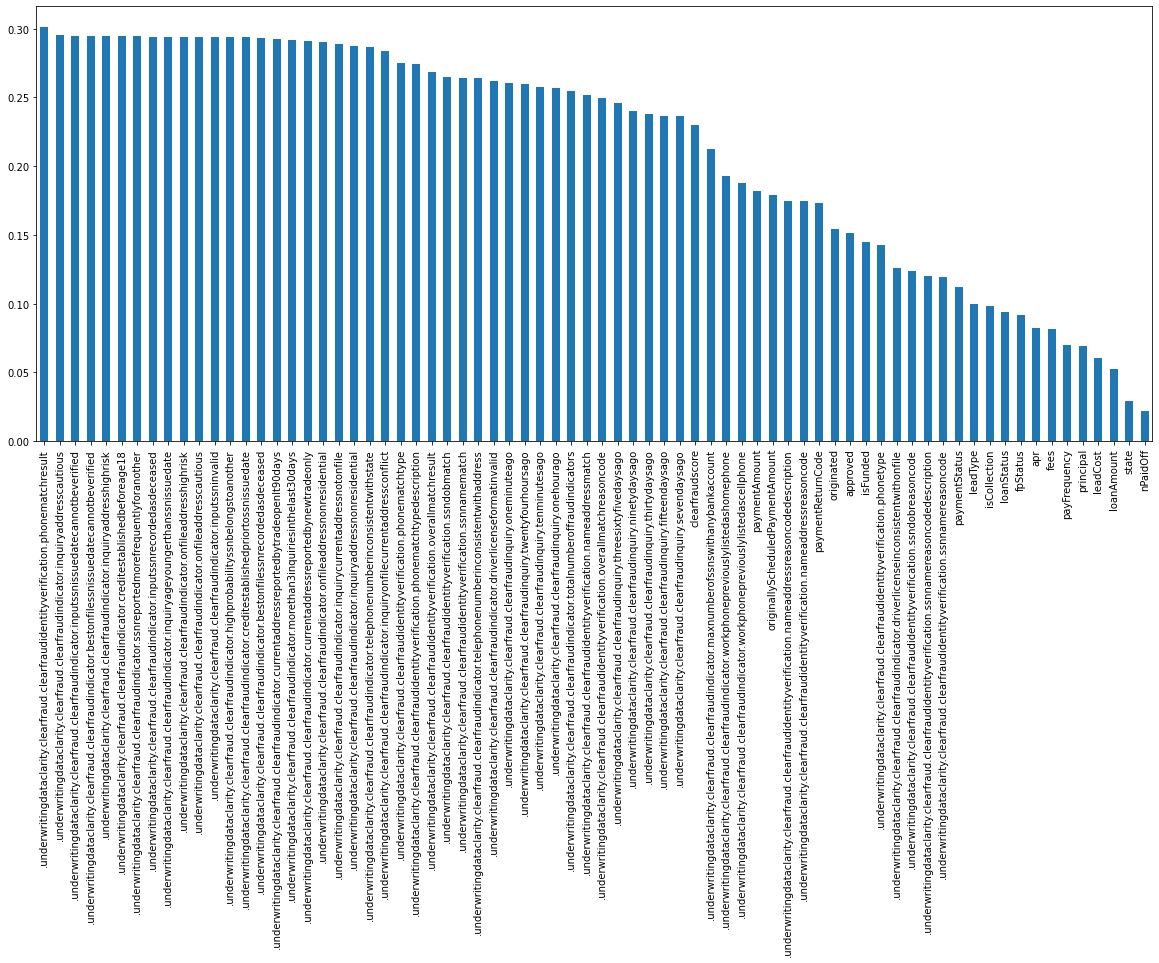

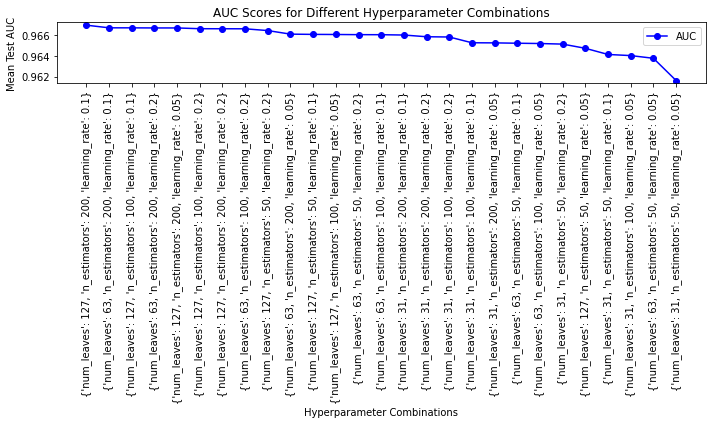

Optimal Threshold: 0.21402551239109457
Optimal threshold saved at C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\preprocessors\threshold.pkl
Training AUC: 0.9686
Testing AUC: 0.9668


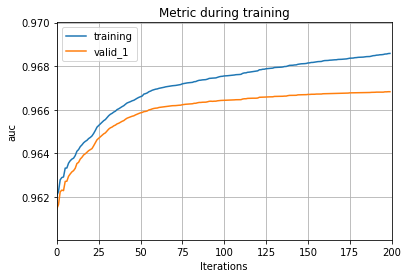

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82     65689
           1       0.99      0.84      0.91    179728

    accuracy                           0.88    245417
   macro avg       0.84      0.91      0.86    245417
weighted avg       0.91      0.88      0.89    245417

Confusion matrix

 [[ 64522   1167]
 [ 28046 151682]]

True Positives (TP) =  151682

True Negatives (TN) =  64522

False Positives (FP) =  1167

False Negatives (FN) =  28046


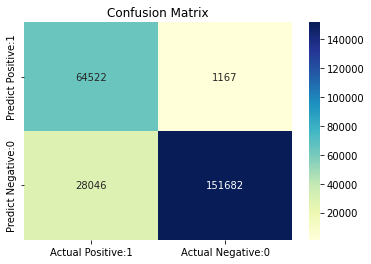

Model saved to C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\model\lgm_loan_fraud_detection_model.pkl


In [4]:
# Initialize the pipeline with configurations
pipeline = AutoMLPipeline(
    target_col = 'hasCF', # Select the target column for data set
    model_type = 'lightgbm', # Select the Model type
    # Select the input features for data set
    input_features = ['payFrequency', 'apr', 'originated', 'nPaidOff', 'approved', 'isFunded', 'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost', 'fpStatus', 'isCollection', 'principal', 'fees', 'paymentAmount', 'paymentStatus', 'paymentReturnCode', '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict', '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious', '.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode', 'clearfraudscore'],
    feature_selection_threshold = 0.05 # Set the threshold value for feature selection using mutual information
)

# Execute the pipeline
model = pipeline.execute_pipeline(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\New_data\merged_data.csv')

# **Conclusion Based on Analysis of  Loan Fraud Detection Model**

The loan fraud detection model shows a strong ability to detect fraudulent cases, with 151,682 true positives and only 1,167 false positives. Prioritizing recall is crucial here, as it reduces the number of false negatives (28,046), meaning fewer fraudulent cases go undetected. This high recall rate makes the model particularly effective for fraud detection, as missing fraud (false negatives) can lead to significant financial risk. The results suggest that while the model is generally accurate, future adjustments could focus on further minimizing false negatives to enhance protection against fraud and increase overall model reliability.

In [5]:

class DeploymentPipeline:
    def __init__(self, target_col, save_dir=r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\preprocessors'):
        """
        Initialize the deployment pipeline with target column and directory where encoders and imputer are stored.

        Parameters:
        - target_col: str - The target column in the dataset.
        - save_dir: str - The directory path where encoders, imputer, and model are saved.
        """
        self.target_col = target_col
        self.save_dir = save_dir
        self.encoders = {}
        self.imputer = None
        self.selected_features = None
        self.load_encoders_and_imputer()
        self.load_selected_features()

    def load_encoders_and_imputer(self):
        """
        Load saved encoders and imputer from the specified directory.
        """
        # Load each encoder
        for col in self.get_saved_encoders():
            self.encoders[col] = joblib.load(f"{self.save_dir}\\{col}_encoder.pkl")

        # Load the imputer
        self.imputer = joblib.load(f"{self.save_dir}\\imputer.pkl")

        print("Encoders and imputer loaded successfully.")


    def get_saved_encoders(self):
        """
        List of column names for which encoders are saved by checking files in save_dir.
        """
        encoder_columns = []
        for file in os.listdir(self.save_dir):
            if file.endswith("_encoder.pkl"):
                col_name = file.replace("_encoder.pkl", "")
                encoder_columns.append(col_name)
        return encoder_columns

    def load_selected_features(self):
        """
        Load the list of selected features used in training from a file.
        """
        self.selected_features = joblib.load(f"{self.save_dir}\\selected_features.pkl")
        print("Selected features loaded successfully.")

    def preprocess_new_data(self, new_data):
        """
        Preprocess new data by applying saved same encoders and imputer.

        Parameters:
        - new_data:  New dataset to preprocess for deployment
        Returns reprocessed feature data ready for model predictions.

        """
        # Define input features used during training
        input_features=['payFrequency', 'apr', 'originated', 'nPaidOff', 'approved', 'isFunded', 'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost', 'fpStatus', 'isCollection', 'principal', 'fees', 'paymentAmount', 'paymentStatus', 'paymentReturnCode', '.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago', '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict', '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious', '.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days', '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid', '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk', '.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified', '.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother', '.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount', '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased', '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly', '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18', '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate', '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone', '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch', '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode', 'clearfraudscore']

        # Ensure only columns that were used in training are processed
        new_data = new_data[input_features].copy()

        # Separate categorical columns from new data
        categorical_cols = new_data.select_dtypes(include=['object', 'category']).columns.tolist()

        # Apply same training encoders to categorical columns
        for col, encoder in self.encoders.items():
            if col in categorical_cols:
                new_data[col] = encoder.transform(new_data[col].astype(str))

         # Apply same trainig imputer to new data
        new_data_imputed = self.imputer.transform(new_data)

        # Create a DataFrame for the imputed data
        new_data_imputed_df = pd.DataFrame(new_data_imputed, columns=new_data.columns)

        return new_data_imputed_df[self.selected_features]


# Load the saved LightGBM model
model_path = r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\model\lgm_loan_fraud_detection_model.pkl'
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")

# Initialize the deployment pipeline
deployment_pipeline = DeploymentPipeline(target_col='hasCF')

# Load new data for testing and select a inference point
test_sample = pd.read_csv(r'C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\New_data\test_sample.csv')
single_row = test_sample.iloc[[0]] # load 1st row from the new data

# Preprocess the inference point test data
new_X_test_single = deployment_pipeline.preprocess_new_data(single_row)

# Get the true target value for inference point
new_y_test_single = single_row[deployment_pipeline.target_col].values[0]

# Predict probability for a inference point
prediction_proba_single = loaded_model.predict_proba(new_X_test_single)[:, 1][0]

# Load the Optimal Threshold of LGMClassifier
LGMClassifier_Optimal_Threshold = joblib.load(r"C:\Users\luxsh\Desktop\Ass\MLE Assessment\part3\preprocessors\threshold.pkl")
print(f"LGMClassifier Optimal Threshold Value: {LGMClassifier_Optimal_Threshold}")

# Print the output and target values
print(f"True Target Value: {new_y_test_single}")
print(f"Predicted Probability: {prediction_proba_single}")

if prediction_proba_single > LGMClassifier_Optimal_Threshold:
    print("prediction probability > LGMClassifier Optimal Threshold, so the target is in the 1 Class")
else:
    print("prediction probability  <= LGMClassifier Optimal Threshold, so the target is in the 0 Class")


Model loaded successfully.
Encoders and imputer loaded successfully.
Selected features loaded successfully.
LGMClassifier Optimal Threshold Value: 0.21402551239109457
True Target Value: 1
Predicted Probability: 0.23533694845364028
prediction probability > LGMClassifier Optimal Threshold, so the target is in the 1 Class
